In [1]:
import warnings
warnings.filterwarnings('ignore')

### Датасет: https://www.kaggle.com/datasets/pkdarabi/cardetection/data

#### Содержит картинки различных дорожных знаков (15 классов) и bound boxes для них. Также для визуализации результата в датасете хранится видео, где в компьютерной симуляции едет машина.
#### Предлагается дообучить модель для детекции на датасете и предсказать видео (расставить bound boxes в нём).

In [2]:
import kagglehub
pkdarabi_cardetection_path = kagglehub.dataset_download('pkdarabi/cardetection')

print('Data source import complete.')


Data source import complete.


In [3]:
! pip install ultralytics -q

In [34]:
import matplotlib.pyplot as plt
import os

import random

from PIL import Image

from ultralytics import YOLO

import glob
import cv2

import yaml

from IPython.display import Video

In [5]:
test_dir = pkdarabi_cardetection_path + '/car/test'
train_dir = pkdarabi_cardetection_path + '/car/train'
test_image_dir = test_dir + '/images'
train_image_dir = train_dir + '/images'

data_yml_path = pkdarabi_cardetection_path + '/car' + '/data.yaml'

In [6]:
def show_images(path, number=16, nrow=4, ncol=4):

    original_state = random.getstate()
    random.seed(42)

    files = os.listdir(path)

    images = random.sample(files, number)
    random.setstate(original_state)

    fig, axs = plt.subplots(nrow, ncol, figsize=(6, 6))
    axs = axs.ravel()

    for idx, img_name in enumerate(images):
        if idx < nrow * ncol:
            img_path = os.path.join(path, img_name)
            img = plt.imread(img_path)
            
            axs[idx].imshow(img)
            axs[idx].axis('off')

#### Примеры картинок из датасета

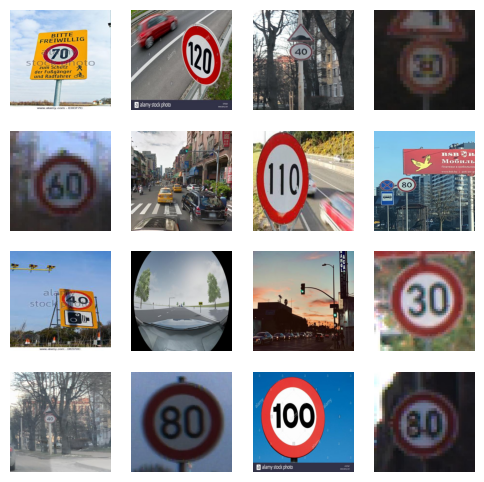

In [7]:
show_images(test_image_dir)

In [8]:
def get_classes_from_yaml(yaml_path):
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    names_list = data['names']
    classes_map = {i: name for i, name in enumerate(names_list)}
    
    return classes_map

In [9]:
true_classes_map = get_classes_from_yaml(data_yml_path)

In [11]:
def read_labels(file_path):
    labels = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_id, center_x, center_y, width, height = map(float, line.strip().split())
            labels.append({
                'class_id': int(class_id),
                'center_x': center_x,
                'center_y': center_y,
                'width': width,
                'height': height
            })
    return labels

def draw_bounding_boxes(image, labels, classes_map):
    h, w = image.shape[:2]
    for label in labels:
        cx = int(label['center_x'] * w)
        cy = int(label['center_y'] * h)
        bw = int(label['width'] * w)
        bh = int(label['height'] * h)
        
        x1 = max(int(cx - bw // 2), 0)
        y1 = max(int(cy - bh // 2), 0)
        
        x2 = min(x1 + bw, w)
        y2 = min(y1 + bh, h)
        
        color = (0, 255, 0)

        class_name = classes_map.get(label['class_id'], f'class_{label["class_id"]}')
        
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness=2)

        font = cv2.FONT_HERSHEY_SIMPLEX
        text_size = cv2.getTextSize(class_name, font, 0.5, 1)[0]
        
        cv2.rectangle(image, (x1, y1 - text_size[1] - 5), (x1 + text_size[0], y1), color, -1)
        
        cv2.putText(image, class_name, (x1, y1 - 5), font, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    return image

def show_model_prediction(model, path, number=16, nrow=6, ncol=2):

    original_state = random.getstate()
    random.seed(0)

    images_path = path + '/images'
    labels_path = path + '/labels'

    image_files = sorted(glob.glob(os.path.join(images_path, '*.jpg')))
    selected_images = random.sample(image_files, min(number, len(image_files)))

    random.setstate(original_state)

    fig = plt.figure(figsize=(16, 16))
    
    gs_pred = plt.GridSpec(nrow, ncol, left=0.02, right=0.48)

    gs_gt = plt.GridSpec(nrow, ncol, left=0.52, right=0.98)
    
    plt.figtext(0.25, 0.95, "PREDICTED", ha='center', va='center', fontsize=16, fontweight='bold')
    plt.figtext(0.75, 0.95, "GROUND TRUTH", ha='center', va='center', fontsize=16, fontweight='bold')

    for idx, img_file in enumerate(selected_images):
        img = cv2.imread(img_file)
        base_name = os.path.splitext(os.path.basename(img_file))[0]
        txt_file = os.path.join(labels_path, base_name + '.txt')

        true_labels = read_labels(txt_file)

        results = model.predict(source=img_file, verbose=False)[0]

        if len(results) == 0:
            pred_annotated_img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #print(f"No objects detected in {base_name}")
        else:
            pred_annotated_img = results.plot(line_width=1)
            pred_annotated_img_rgb = cv2.cvtColor(pred_annotated_img, cv2.COLOR_BGR2RGB)
        
        ax_pred = fig.add_subplot(gs_pred[idx // ncol, idx % ncol])
        ax_pred.imshow(pred_annotated_img_rgb)
        ax_pred.axis('off')
        ax_pred.set_title(f"Image {idx+1}", fontsize=8)

        gt_annotated_img = draw_bounding_boxes(img.copy(), true_labels, true_classes_map)
        gt_annotated_img_rgb = cv2.cvtColor(gt_annotated_img, cv2.COLOR_BGR2RGB)
        
        ax_gt = fig.add_subplot(gs_gt[idx // ncol, idx % ncol])
        ax_gt.imshow(gt_annotated_img_rgb)
        ax_gt.axis('off')
        ax_gt.set_title(f"Image {idx+1}", fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

### В качестве модели будет использоваться YOLOv8 Nano, так как данная модель обладает хорошим соотношением качество/быстродействие

In [10]:
model = YOLO("yolov8n.pt")

#### Результаты модели до обучения

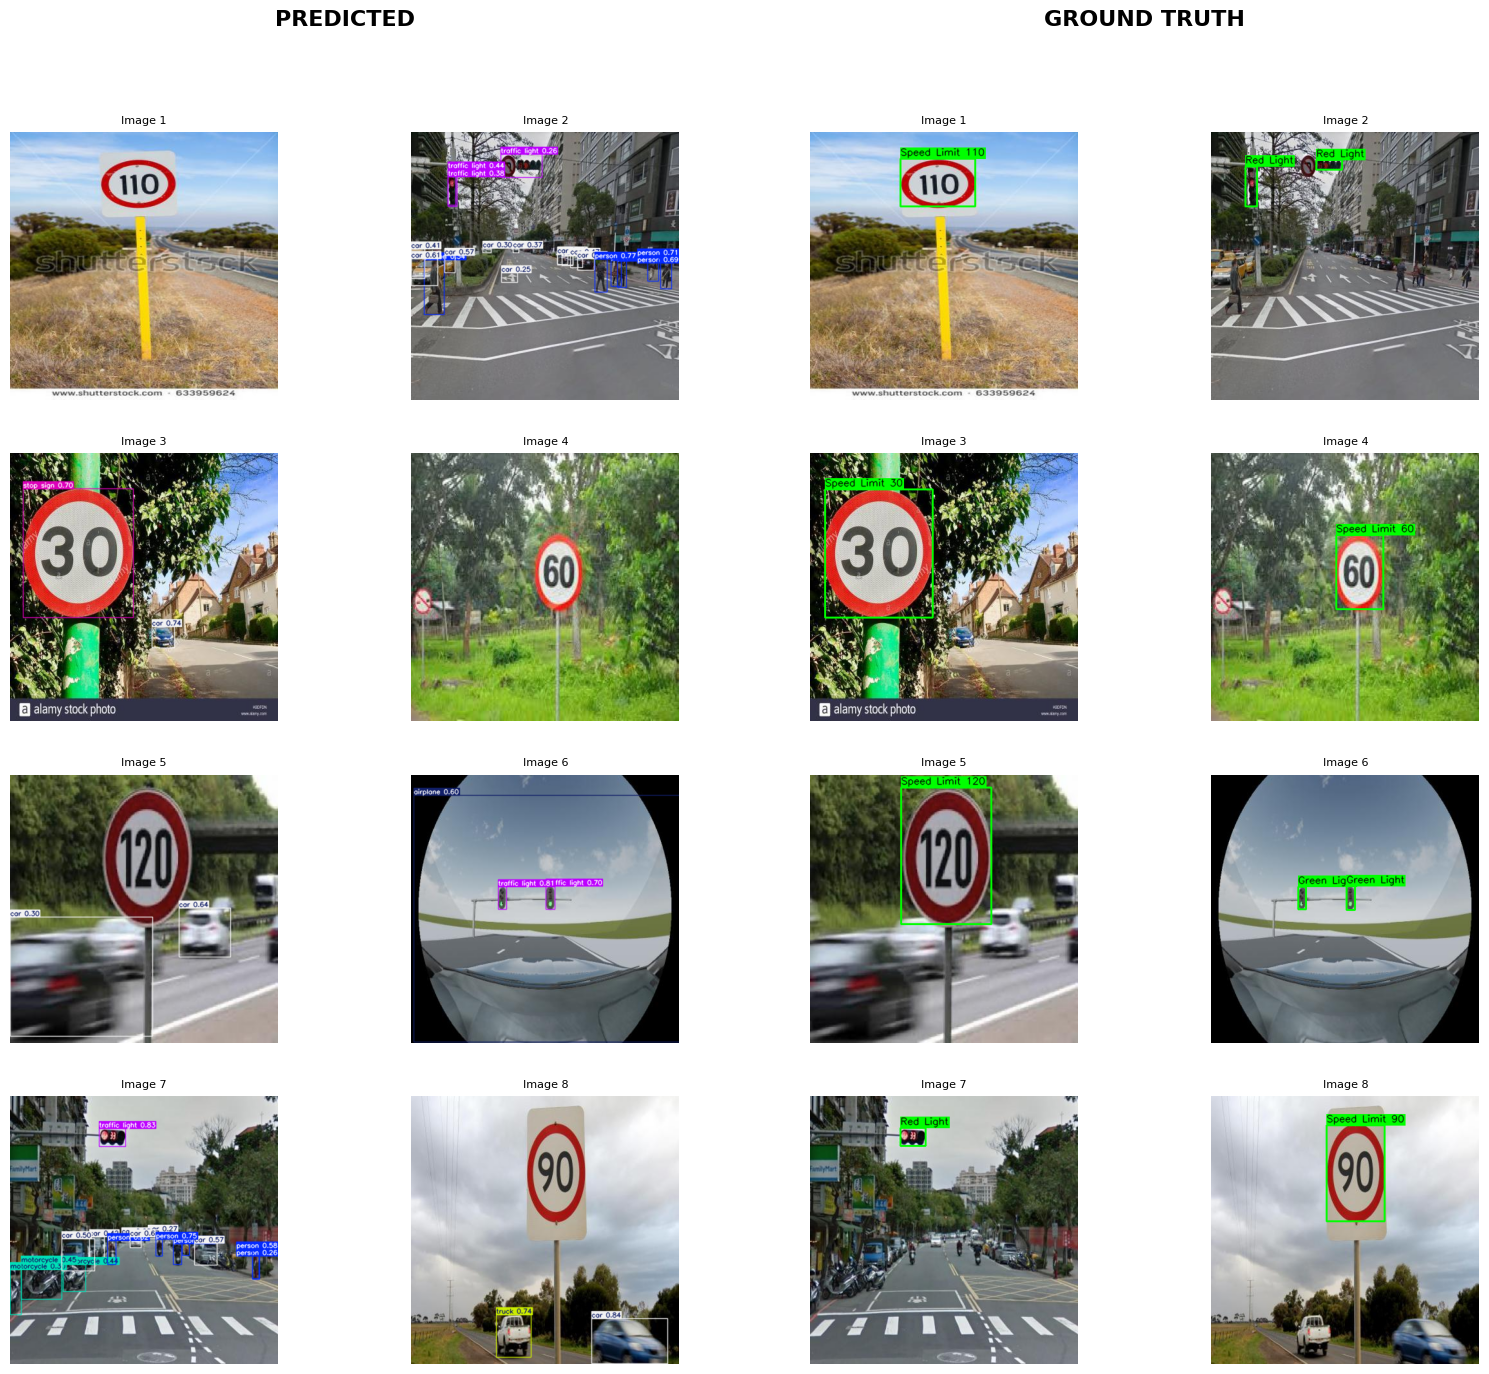

In [12]:
show_model_prediction(model, test_dir, 8, 4, 2)

### Обучение

In [13]:
result = model.train(data=data_yml_path, epochs=30)

Ultralytics 8.3.185 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/michael/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

train: Scanning /home/michael/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/train/labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 429.7±342.7 MB/s, size: 20.7 KB)


val: Scanning /home/michael/.cache/kagglehub/datasets/pkdarabi/cardetection/versions/5/car/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.06G      1.662      4.041      1.783         21        640: 100%|██████████| 221/221 [00:39<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


                   all        801        944      0.129      0.421      0.171      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.38G     0.8728      2.782      1.221         14        640: 100%|██████████| 221/221 [00:36<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.87it/s]

                   all        801        944      0.275      0.428        0.3      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.39G      0.784       2.32      1.141         23        640: 100%|██████████| 221/221 [00:36<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:07<00:00,  3.71it/s]

                   all        801        944      0.303      0.495      0.362      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.39G     0.7366      2.011      1.097         20        640: 100%|██████████| 221/221 [00:38<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.43it/s]

                   all        801        944      0.498      0.395      0.437      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.39G     0.7115      1.774      1.069         34        640: 100%|██████████| 221/221 [00:36<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.32it/s]

                   all        801        944      0.482      0.534      0.544      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.39G     0.6918       1.57      1.067         15        640: 100%|██████████| 221/221 [00:40<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.27it/s]

                   all        801        944      0.573      0.612      0.644      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.39G     0.6711      1.423      1.049         27        640: 100%|██████████| 221/221 [00:38<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.33it/s]

                   all        801        944      0.707      0.675       0.73      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.39G     0.6668      1.315      1.054         26        640: 100%|██████████| 221/221 [00:38<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.31it/s]

                   all        801        944       0.78      0.684      0.764      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       2.4G     0.6491      1.219      1.028         31        640: 100%|██████████| 221/221 [00:40<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.31it/s]

                   all        801        944      0.825      0.726      0.815      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       2.4G     0.6348      1.133      1.022         26        640: 100%|██████████| 221/221 [00:38<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.24it/s]

                   all        801        944      0.792      0.764      0.826      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       2.4G     0.6331      1.064      1.016         18        640: 100%|██████████| 221/221 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:07<00:00,  3.53it/s]

                   all        801        944      0.882      0.749      0.852       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       2.4G     0.6233      1.024      1.013         17        640: 100%|██████████| 221/221 [00:39<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.52it/s]

                   all        801        944      0.853      0.782      0.862      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.41G     0.6133     0.9753      1.013         23        640: 100%|██████████| 221/221 [00:39<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.48it/s]

                   all        801        944      0.899      0.768      0.868      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.41G     0.5986     0.9293     0.9998         26        640: 100%|██████████| 221/221 [00:39<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.28it/s]

                   all        801        944      0.896      0.783      0.879      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.41G     0.6084     0.9195      1.002         24        640: 100%|██████████| 221/221 [00:37<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.38it/s]

                   all        801        944       0.87      0.798      0.872      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.41G     0.6075     0.9074      1.006         24        640: 100%|██████████| 221/221 [00:38<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]

                   all        801        944      0.924      0.764      0.882       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.41G      0.589     0.8711     0.9957         23        640: 100%|██████████| 221/221 [00:39<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.23it/s]

                   all        801        944      0.893       0.81      0.894      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.41G     0.5846     0.8336      0.995         19        640: 100%|██████████| 221/221 [00:38<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.56it/s]

                   all        801        944      0.884      0.803      0.881      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.41G     0.5789     0.8089     0.9856         24        640: 100%|██████████| 221/221 [00:38<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.39it/s]

                   all        801        944      0.894      0.818      0.898      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.41G     0.5805     0.8034     0.9917         30        640: 100%|██████████| 221/221 [00:39<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.48it/s]

                   all        801        944      0.903      0.824      0.902       0.78


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.41G     0.5757     0.6046     0.9608         12        640: 100%|██████████| 221/221 [00:39<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.71it/s]

                   all        801        944      0.915      0.822      0.907      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.41G     0.5662     0.5794     0.9477         18        640: 100%|██████████| 221/221 [00:38<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:06<00:00,  4.31it/s]

                   all        801        944      0.925      0.837      0.919      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.41G     0.5549     0.5545     0.9472         12        640: 100%|██████████| 221/221 [00:38<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.60it/s]

                   all        801        944      0.919      0.837      0.915      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.41G     0.5587     0.5373     0.9461         10        640: 100%|██████████| 221/221 [00:37<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.47it/s]

                   all        801        944      0.962       0.82      0.924      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.41G      0.555     0.5158     0.9438         12        640: 100%|██████████| 221/221 [00:37<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.38it/s]

                   all        801        944      0.912      0.846      0.922      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.41G     0.5412     0.4993     0.9345          9        640: 100%|██████████| 221/221 [00:38<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.49it/s]

                   all        801        944      0.933      0.852      0.925      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.41G      0.544     0.4979     0.9343         15        640: 100%|██████████| 221/221 [00:36<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.44it/s]

                   all        801        944      0.924      0.867      0.931      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.41G     0.5351     0.4813     0.9296         10        640: 100%|██████████| 221/221 [00:37<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.36it/s]

                   all        801        944      0.928      0.857       0.93      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.41G     0.5318     0.4651     0.9252         12        640: 100%|██████████| 221/221 [00:37<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.39it/s]

                   all        801        944      0.937      0.851      0.928      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.41G     0.5252      0.467     0.9258         13        640: 100%|██████████| 221/221 [00:37<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:05<00:00,  4.49it/s]

                   all        801        944      0.927      0.844      0.928        0.8



30 epochs completed in 0.375 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.185 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 26/26 [00:07<00:00,  3.62it/s]


                   all        801        944      0.919      0.872      0.931      0.804
           Green Light         87        122      0.867       0.68      0.776      0.451
             Red Light         74        108       0.78      0.759       0.78      0.465
       Speed Limit 100         52         52      0.857      0.942       0.97      0.892
       Speed Limit 110         17         17      0.892      0.975      0.972      0.911
       Speed Limit 120         60         60      0.982      0.885      0.986      0.907
        Speed Limit 20         56         56      0.972      0.929      0.977       0.84
        Speed Limit 30         71         74      0.888      0.919      0.967      0.912
        Speed Limit 40         53         55      0.891      0.909      0.971      0.863
        Speed Limit 50         68         71      0.951      0.803      0.916      0.826
        Speed Limit 60         76         76      0.964      0.908      0.948      0.846
        Speed Limit 7

In [14]:
def show_metrics():
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('YOLO Detection Metrics', fontsize=16, fontweight='bold')

    image_paths = [
        "runs/detect/train/BoxF1_curve.png",
        "runs/detect/train/BoxP_curve.png", 
        "runs/detect/train/BoxPR_curve.png",
        "runs/detect/train/BoxR_curve.png"
    ]

    titles = ['F1 Curve', 'Precision Curve', 'Precision-Recall Curve', 'Recall Curve']

    for i, (ax, img_path, title) in enumerate(zip(axs.flat, image_paths, titles)):
        try:
            img = plt.imread(img_path)
            ax.imshow(img)
            ax.set_title(title, fontsize=12, fontweight='bold')
            ax.axis('off')
        except FileNotFoundError:
            ax.text(0.5, 0.5, f'Image not found:\n{img_path}', 
                    ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

#### Результаты обучения

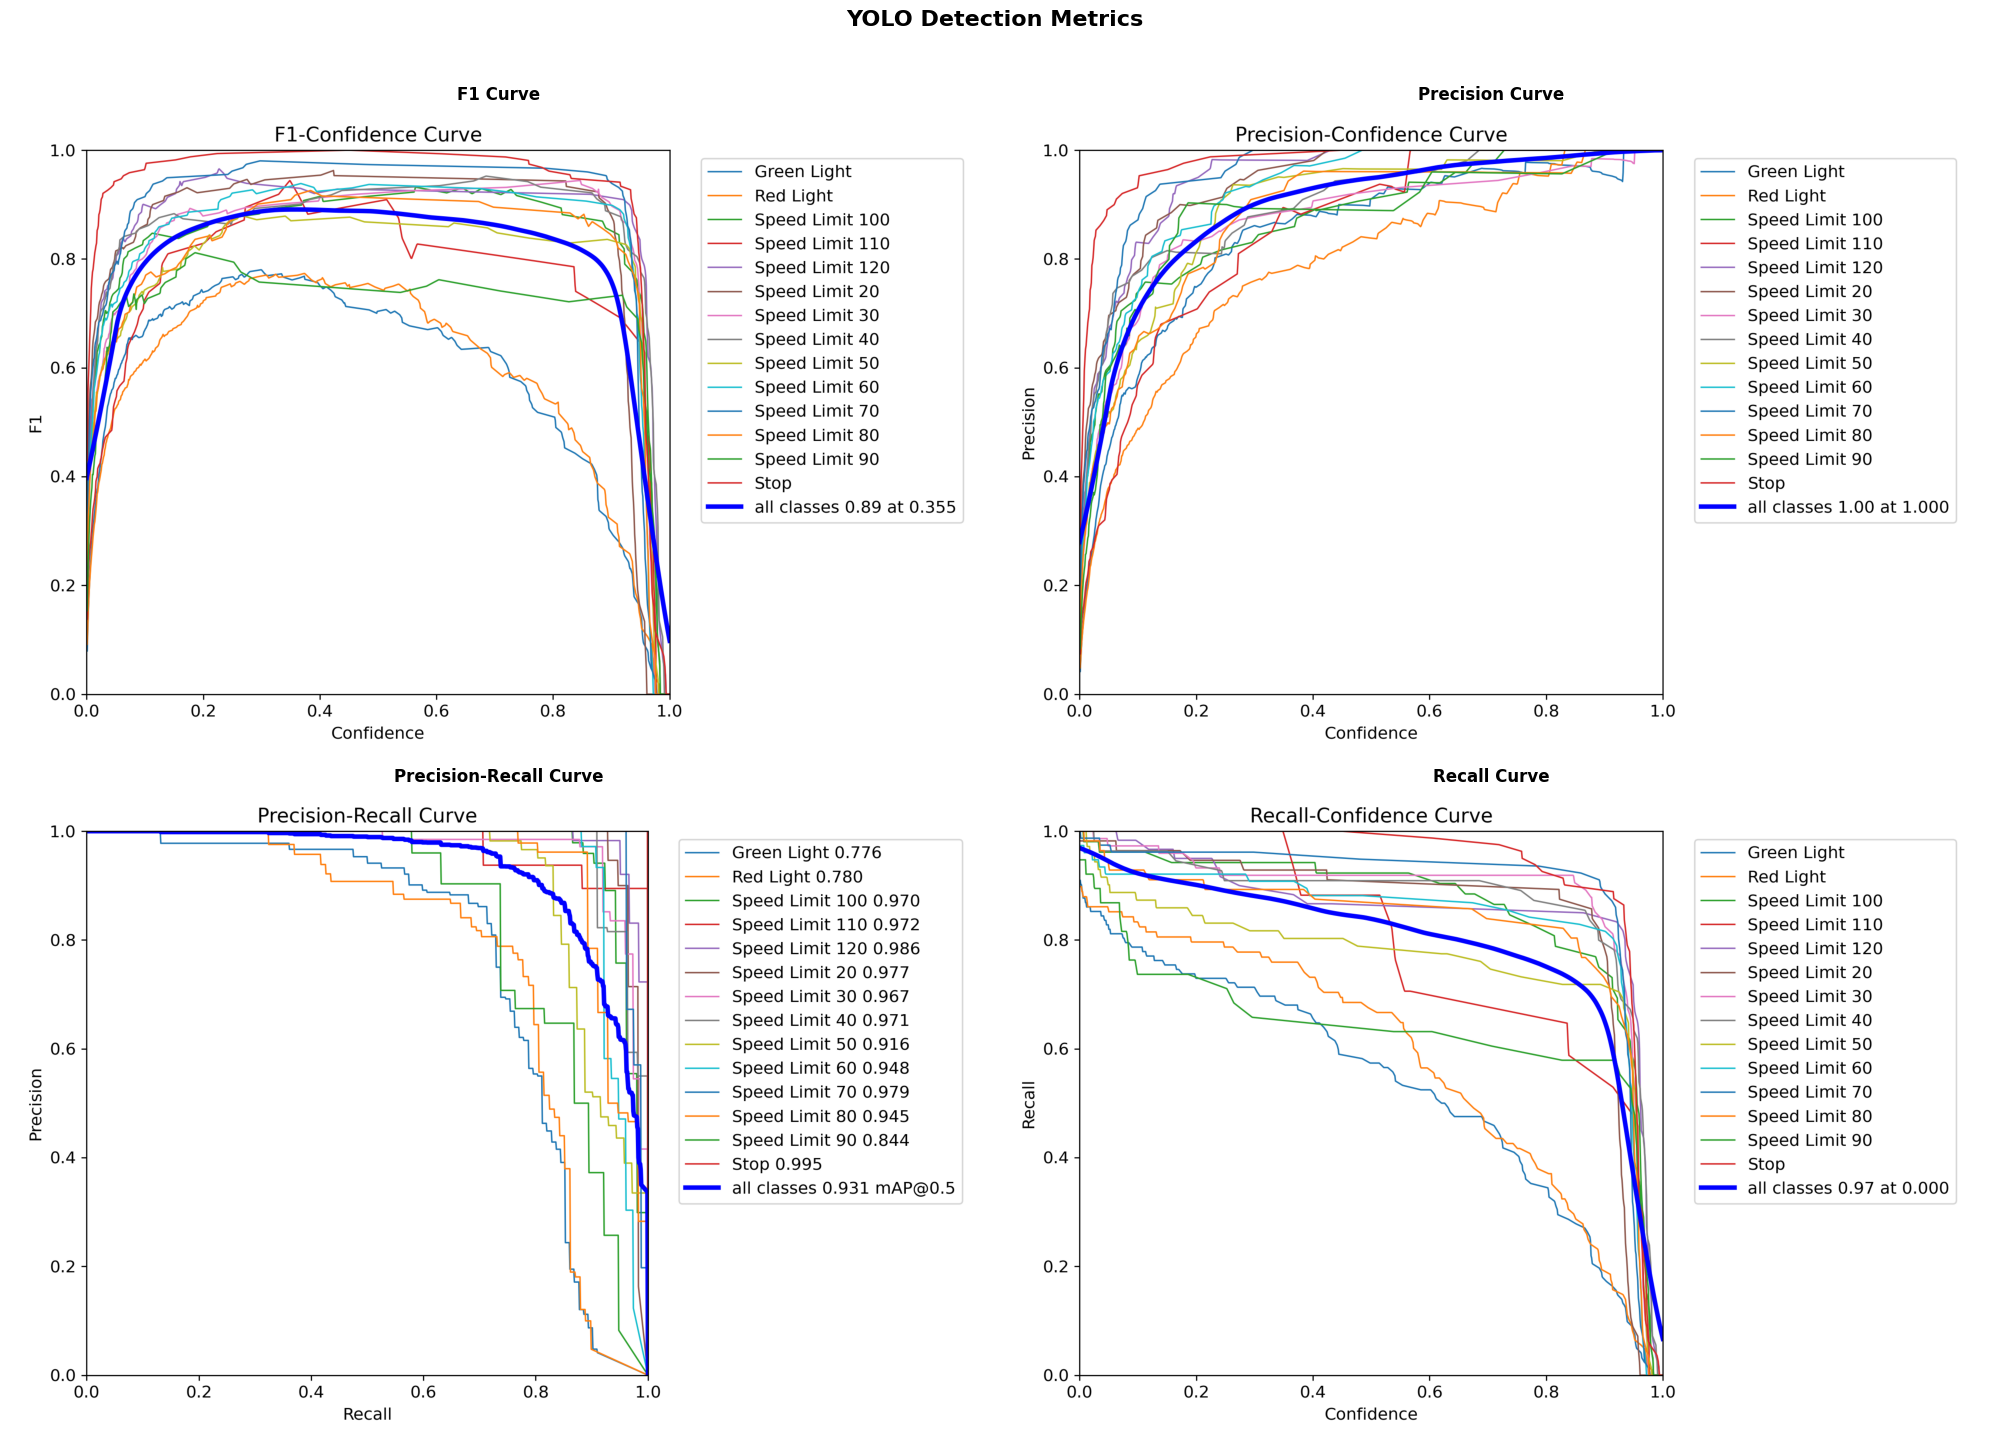

In [15]:
show_metrics()

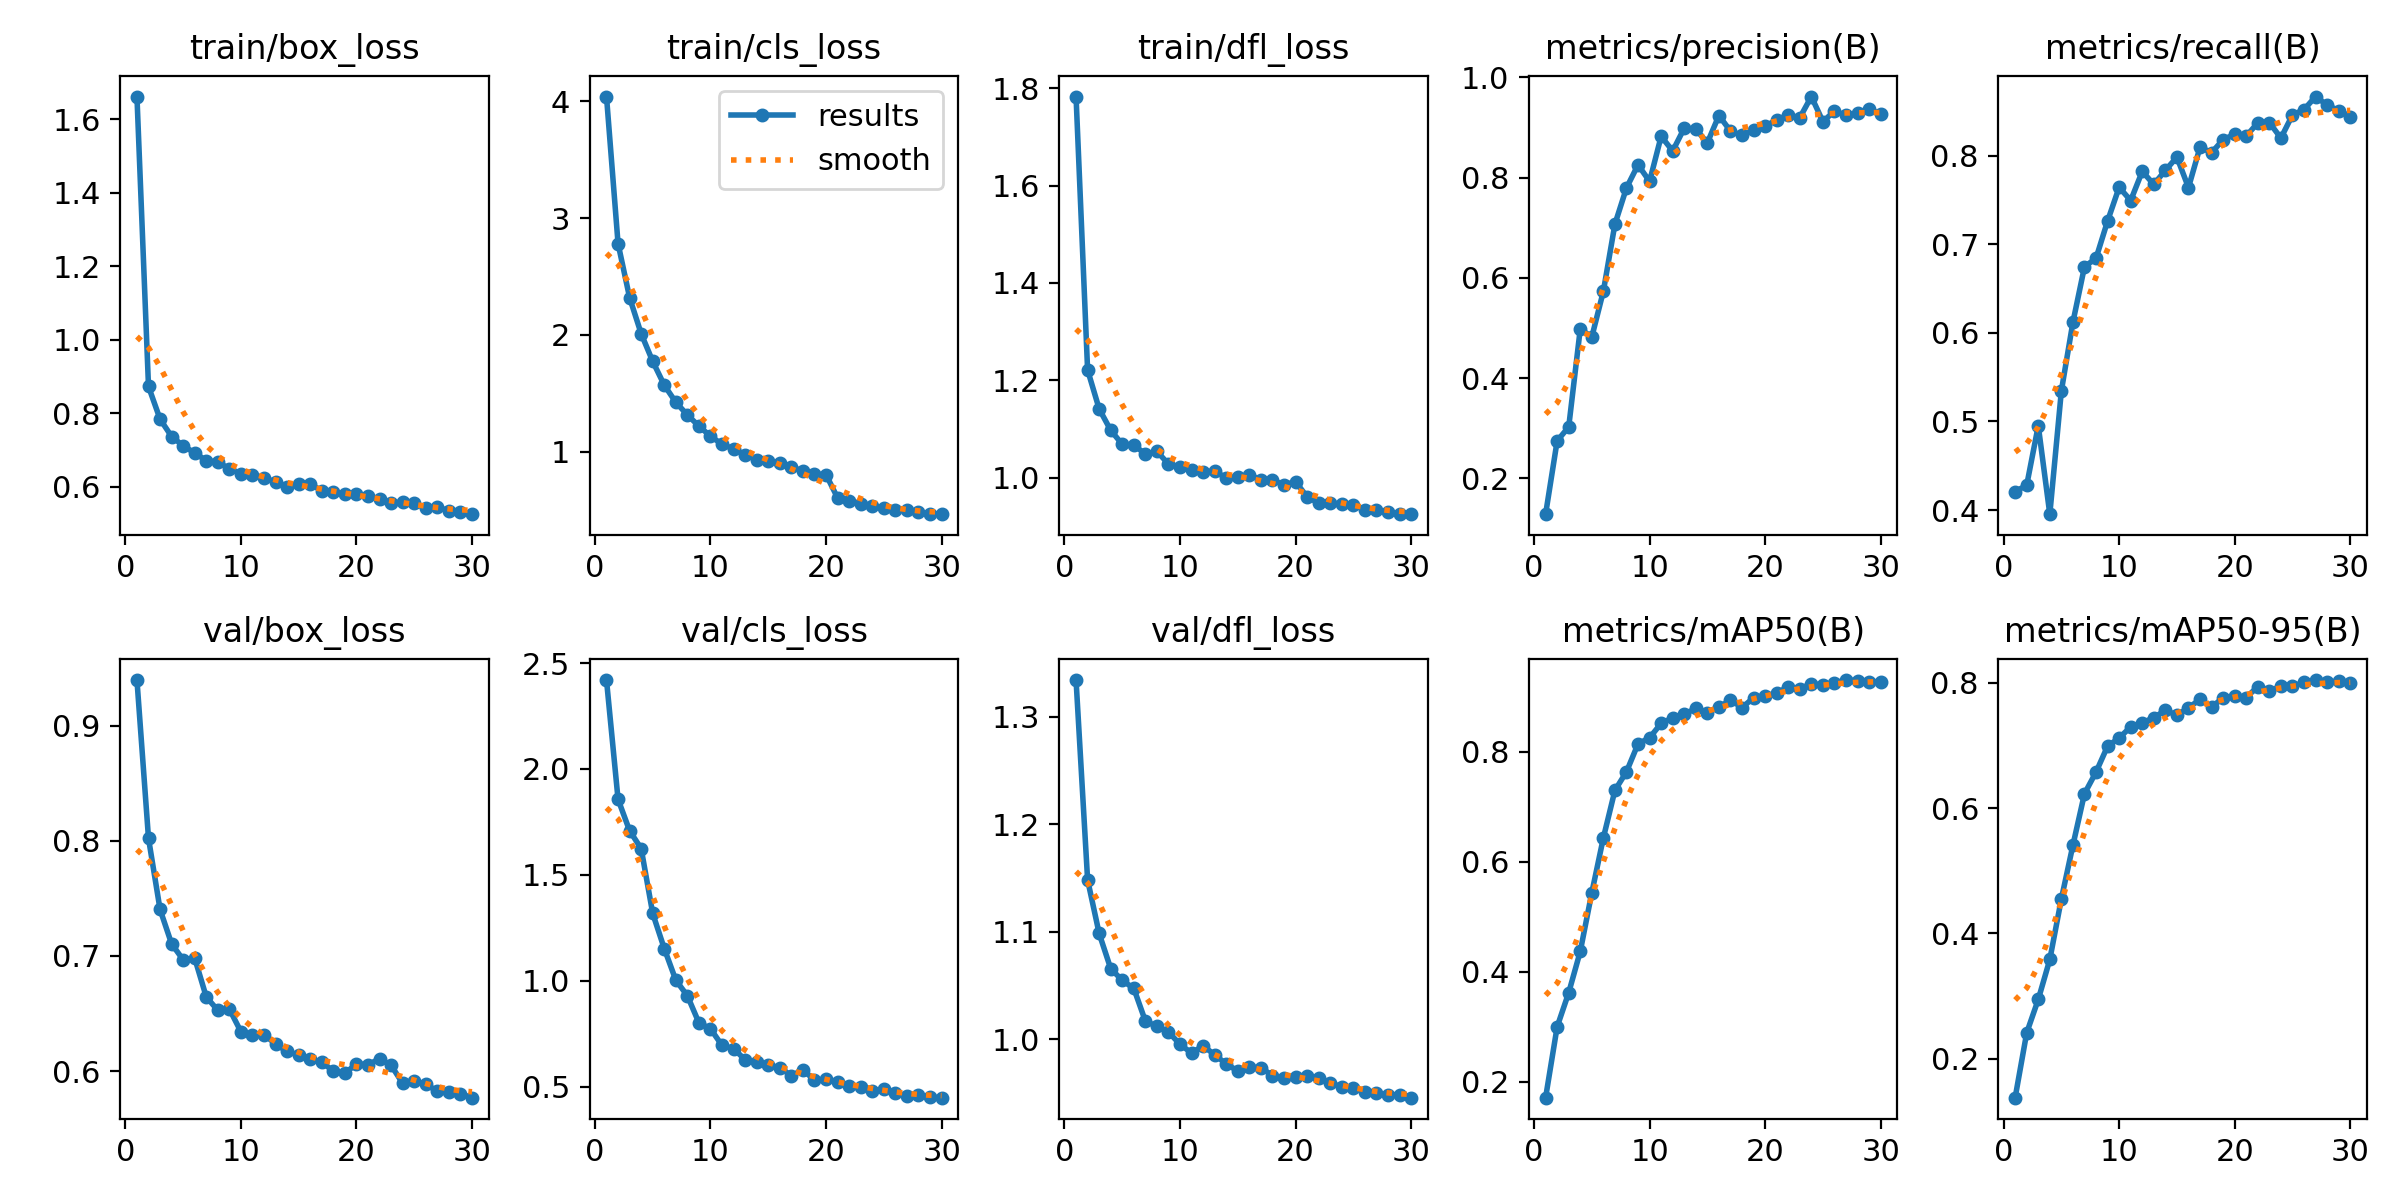

In [16]:
Image("runs/detect/train/results.png")

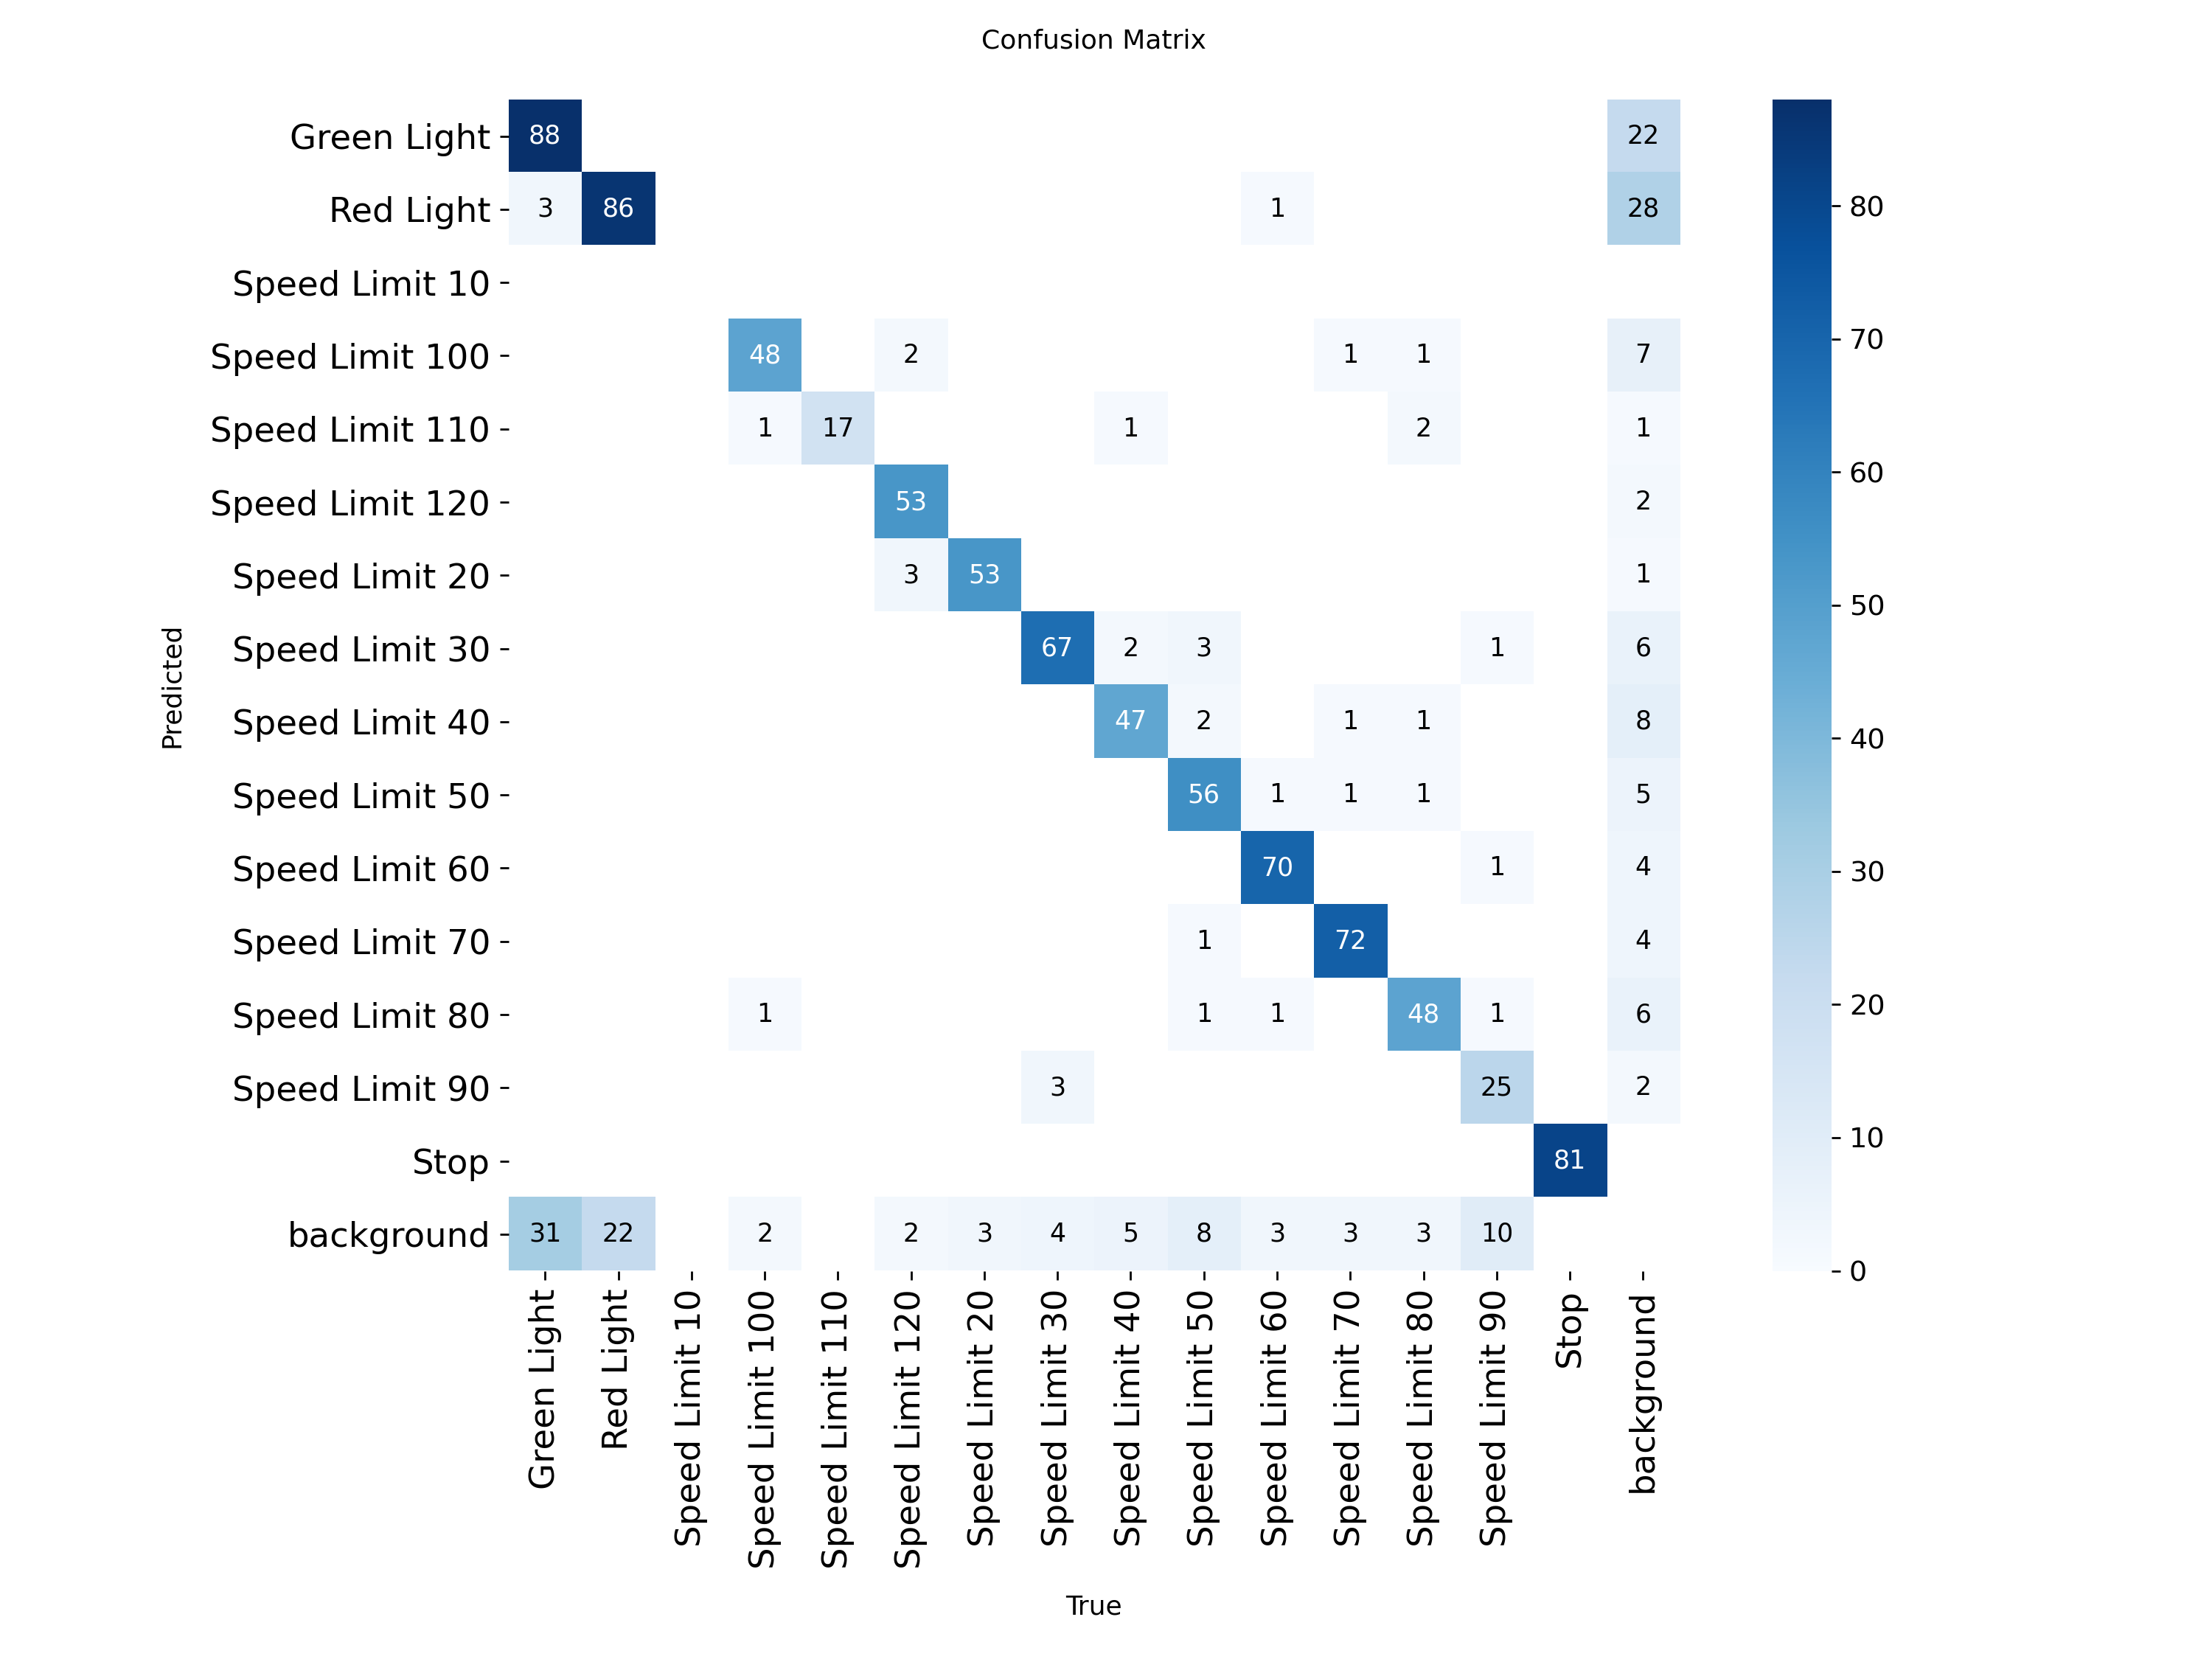

In [17]:
Image("runs/detect/train/confusion_matrix.png")

#### Загрузка лучшей модели

In [18]:
model = YOLO('runs/detect/train/weights/best.pt')

#### Результаты лучшей модели

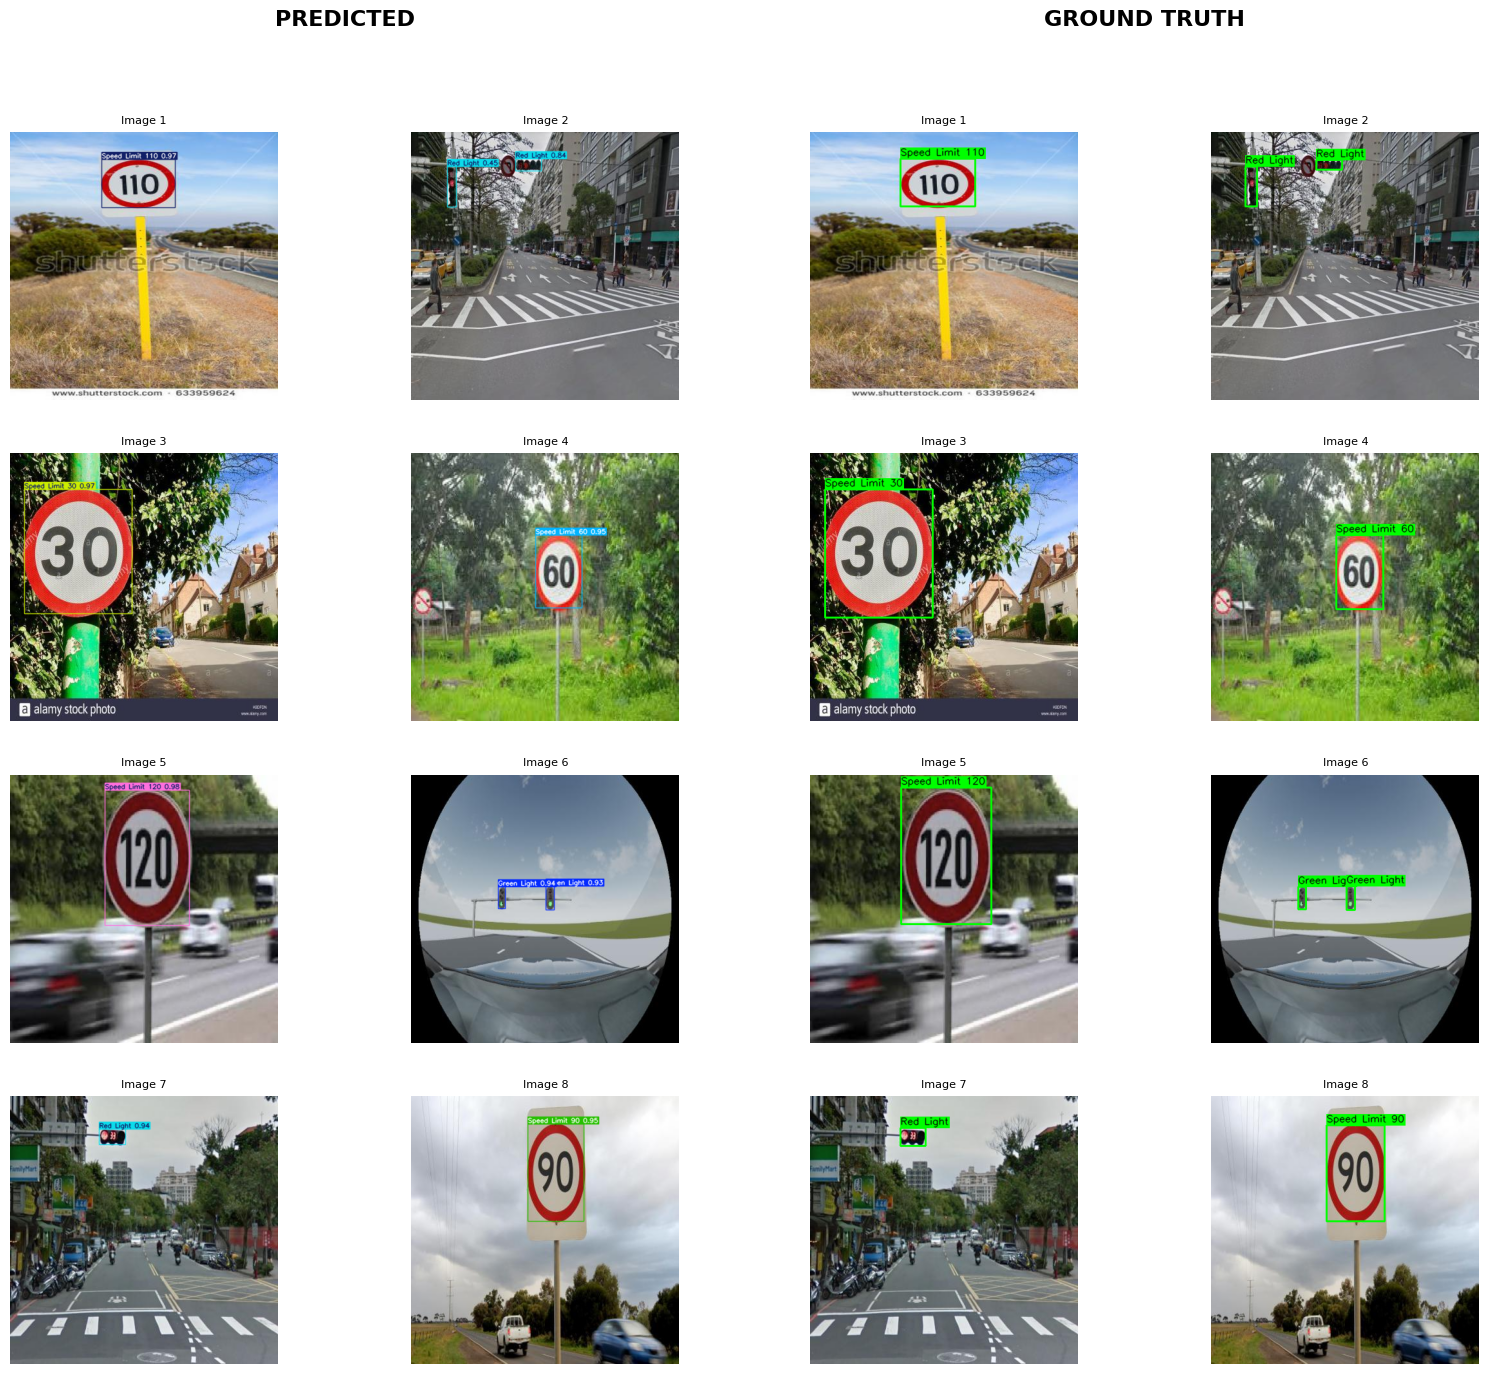

In [19]:
show_model_prediction(model, test_dir, 8, 4, 2)

### Предсказание тестового видео

In [62]:
video_path = f'{pkdarabi_cardetection_path}/video.mp4'

In [63]:
!ffmpeg -y -loglevel panic -i '{video_path}' converted_video.mp4

In [81]:
def process_and_save_video(model, input_path):
    results = model.predict(
        source=input_path,
        conf=0.5,
        save=True,
        save_txt=False,
        project='results',
        name='video_detection',
        exist_ok=True
    )

    output_dir = os.path.join('results', 'video_detection')
    
    avi_files = [f for f in os.listdir(output_dir) if f.endswith('.avi')]
    
    if avi_files:
        actual_output_path = os.path.join(output_dir, avi_files[0])
        return actual_output_path
    else:
        raise FileNotFoundError("Обработанное видео не найдено")

#### Видео до предсказания

In [82]:
Video('converted_video.mp4', 
      width=800,
      height=600, 
      embed=True)

In [83]:
output_path = process_and_save_video(model, 'converted_video.mp4')

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



Results saved to results/video_detection


In [85]:
!ffmpeg -y -loglevel panic -i '{output_path}' converted_output.mp4

#### Видео после предсказания

In [86]:
Video('converted_output.mp4', 
      width=800,
      height=600, 
      embed=True)